# En mode semi-supervisé





In [ ]:
# from google.colab import drive

# drive.mount('/content/drive')
# #, force_remount=True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

170498071/170498071 [==============================] - 13s 0us/step


#### RandAug

In [ ]:
!pip uninstall --yes imgaug
!pip install imgaug==0.4.0

Found existing installation: imgaug 0.4.0
Uninstalling imgaug-0.4.0:
  Successfully uninstalled imgaug-0.4.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 20.3 MB/s eta 0:00:00


In [ ]:
import imgaug.augmenters as iaa
aug = iaa.RandAugment(n=2, m=9)

def randaugment(img):
  return aug(images=img)

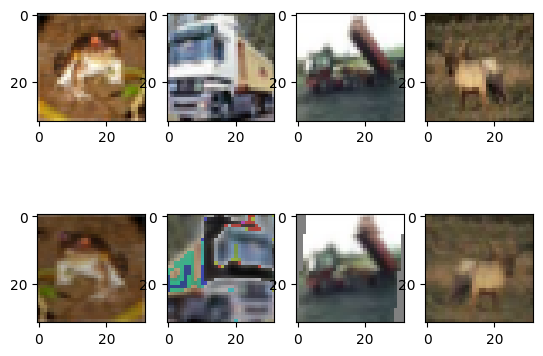

In [ ]:
import matplotlib.pyplot as plt

# Application de RandAugment aux 4 premières images de la base d'entraînement
aug_img = randaugment(x_train[0:4])

# Affichage des images originales (ligne du haut) et augmentées (ligne du bas)
for i in range(4):
  plt.subplot(2,4,i+1)
  plt.imshow(x_train[i])

  plt.subplot(2,4, i+5)
  plt.imshow(aug_img[i])

#### Réseau fourni

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential

def create_model():

  model = Sequential()
  model.add(Conv2D(32, (3,3), padding='same', input_shape=(32,32,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(96, (3,3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Flatten())
  model.add(Dense(512,activation='relu'))
  model.add(Dense(10,activation='softmax'))
  return model

create_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 96)          55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 96)         0

### Préparation de données

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10

def generate_data_cifar(unlab_pourcentage):
    #pourcentage c'est le pourcentage des données non labellisées
    #dans le cas supervisé c'est 1-pourcentage est la quantité des données utilisée pour l'entrainement du modèle

    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    #on génère les données lab et unlab de manière équilibrée vis à vis de la présence des différentes classes
    x_train_lab, x_train_unlab, y_train_lab, y_train_unlab = train_test_split(x_train, y_train, test_size=unlab_pourcentage, random_state=2, stratify=y_train)

    return x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test

### Unlab Losss

In [ ]:
import tensorflow as tf


def unlab_loss(y_weak, y_strong, threshold = 0.95):

    max_probs = tf.math.reduce_max(y_weak, axis=1)
    # tf.print(max_probs)
    pseudo_labels = tf.math.argmax(y_weak, axis=1)
    # tf.print(pseudo_labels)

    mask = tf.math.greater_equal(max_probs, threshold)
    # tf.print(mask)

    pseudo_labels_masked = pseudo_labels[mask]
    # tf.print(pseudo_labels_masked)

    y_strong_masked = y_strong[mask]
    #tf.print(y_strong_masked)


    unsupervised_loss = tf.keras.losses.SparseCategoricalCrossentropy()(pseudo_labels_masked, y_strong_masked)

    return unsupervised_loss

In [ ]:
# y_weak = tf.constant([[0.1, 0.2, 0.6, 0.1], [0.96, 0.01, 0.01, 0.02]])
# y_strong = tf.constant([[0.2, 0.2, 0.5, 0.1], [0.9, 0.04, 0.03, 0.03]])

# tf.print(unlab_loss(y_weak, y_strong))


### Weak Aug

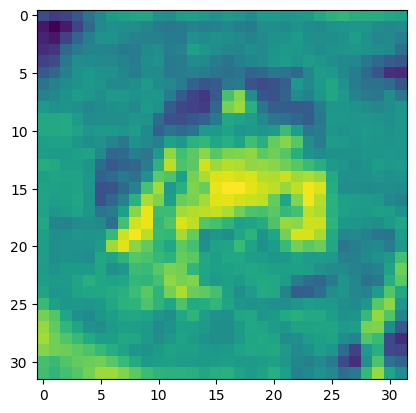

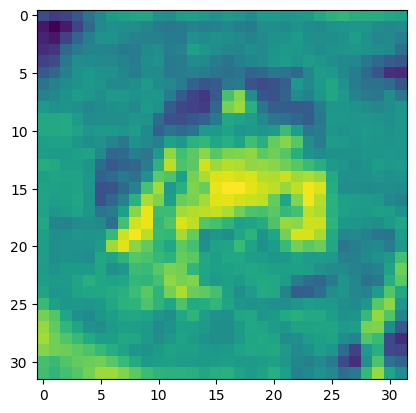

In [ ]:
#### Weak augmentation

from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Initialize ImageDataGenerator with horizontal flip
train_datagen = ImageDataGenerator(horizontal_flip=True)

# Use datagen.flow_from_directory() or datagen.flow() to generate augmented batches
x = x_train[0:10]
plt.imshow(x[0, : ,: ,0])
plt.show()
x_aug = train_datagen.flow(x, shuffle=False, batch_size=10).next()
plt.imshow(x_aug[0, : ,: ,0])
plt.show()


## Fix Match


### Fix Match avec 10% de données labellisées (5000)


In [ ]:
x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test = generate_data_cifar(0.9)

In [ ]:
# x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test = generate_cifar_dataset_perc(labeled_percent=0.1)
# Print shapes
print("Shape of x_train_lab:", np.shape(x_train_lab))
print("Shape of y_train_lab:", np.shape(y_train_lab))
print("Shape of x_train_unlab:", np.shape(x_train_unlab))
print("Shape of y_train_unlab:", np.shape(y_train_unlab))
print("Shape of x_test:", np.shape(x_test))
print("Shape of y_test:", np.shape(y_test))

NameError: ignored

In [ ]:
import os
import pickle

# Specify the directory to save the dataset
dataset_dir = "/content/drive/MyDrive/5 - MODIA/Deep Learning - Project/datasets"
os.makedirs(dataset_dir, exist_ok=True)

# Specify the file path to save the dataset
dataset_file = os.path.join(dataset_dir, "cifar_dataset_2.pkl")

# Prepare the data dictionary
data = {
    "x_train_lab": x_train_lab,
    "y_train_lab": y_train_lab,
    "x_train_unlab": x_train_unlab,
    "y_train_unlab": y_train_unlab,
    "x_test": x_test,
    "y_test": y_test
}

# Save the dataset to the specified file path
with open(dataset_file, 'wb') as file:
    pickle.dump(data, file)


In [ ]:
import pickle

# Load the variables from the file
dataset_file = '/content/drive/MyDrive/5 - MODIA/Deep Learning - Project/datasets/cifar_dataset.pkl'
with open(dataset_file, 'rb') as file:
    loaded_data = pickle.load(file)

# Access the variables
x_train_lab = loaded_data['x_train_lab']
y_train_lab = loaded_data['y_train_lab']
x_train_unlab = loaded_data['x_train_unlab']
y_train_unlab = loaded_data['y_train_unlab']
x_test = loaded_data['x_test']
y_test = loaded_data['y_test']


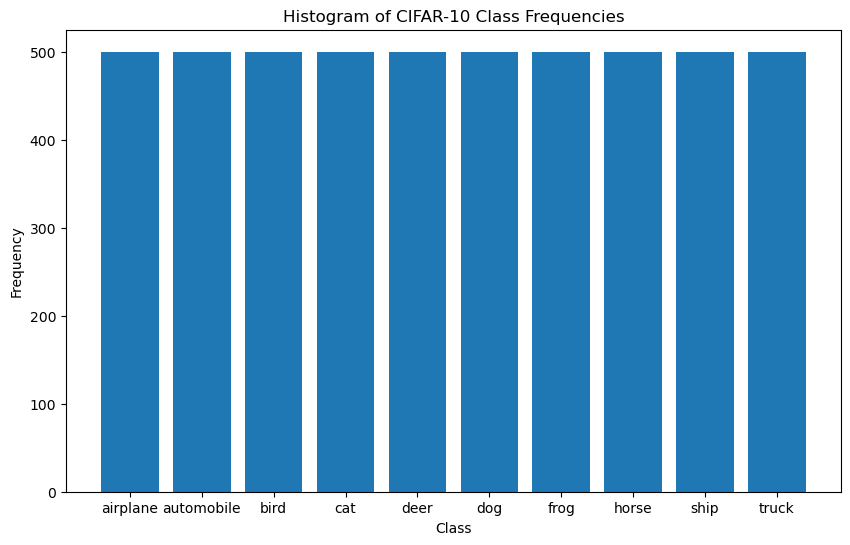

In [ ]:
# Compute class frequencies
class_frequencies = np.histogram(y_train_lab, bins=range(11))[0]

# Plot histogram with increased figure size
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(10), class_frequencies)
ax.set_xticks(range(10))
ax.set_xticklabels(['airplane', 'automobile', 'bird', 'cat', 'deer',
                     'dog', 'frog', 'horse', 'ship', 'truck'])
ax.set_xlabel('Class')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of CIFAR-10 Class Frequencies')
plt.show()


 ALUs (Arithmetic Logical Unit)## Version article


In [ ]:
# import tensorflow as tf
# from tensorflow import keras
# import math
# import os

# # Specify the directory to save the model weights
# weights_dir = "/content/drive/MyDrive/5 - MODIA/Deep Learning - Project"
# os.makedirs(weights_dir, exist_ok=True)

# # Initialisation de l'historique
# history = {"loss": [], "train_acc": [], "test_acc": []}

# # Création du model
# model = create_model()

# # Treshold
# tau = 0.95

# # For example, μ = 2 means that we use twice the number of unlabeled images compared to labeled images.
# mu = 7

# # Unlabeled loss weight
# lambda_u = 10

# # Weight decay coefficient
# weight_decay = 0.0003

# # Nombre d'epochs de l'apprentissage
# epochs = 300

# # Nombre de données labellisées par batch
# bs_lab = 10

# # Nombre de données non-labellisées par batch
# bs_unlab = mu * bs_lab

# # # Taille du batch
# batch_size = bs_lab + bs_unlab

# # Nombre de batches par epochs
# if batch_size < x_train_lab.shape[0]:
#     steps_per_epoch = math.floor(x_train_lab.shape[0] / batch_size)
# else:
#     steps_per_epoch = 1
#     batch_size = x_train_lab.shape[0]

# # Learning rate schedule
# def learning_rate_schedule(epoch):
#     if epoch < 5:
#         lr = (0.4 / 5) * (epoch + 1)
#     elif epoch in [60, 120, 160, 200]:
#         lr = keras.backend.get_value(optimizer.learning_rate) * 0.1
#     else:
#         lr = keras.backend.get_value(optimizer.learning_rate)
#     return lr

# # Exponential moving average (EMA)
# ema = tf.train.ExponentialMovingAverage(decay=0.999)

# # Instanciation d'un optimiseur et d'une fonction de coût.
# optimizer = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9, nesterov=True)

# # Pour la partie supervisée de la perte
# loss_sup = keras.losses.SparseCategoricalCrossentropy()

# # Préparation des métriques pour le suivi de la performance du modèle.
# train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
# test_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# # Indices de l'ensemble non labellisé
# indices_lab = np.arange(x_train_lab.shape[0])
# # Indices de l'ensemble non labellisé
# indices_unlab = np.arange(x_train_unlab.shape[0])

# for epoch in range(epochs):
#     # A chaque nouvelle epoch, on randomise les indices de l'ensemble labellisé
#     np.random.shuffle(indices_lab)

#     # A chaque nouvelle epoch, on randomise les indices de l'ensemble non labellisé
#     np.random.shuffle(indices_unlab)

#     for b in range(steps_per_epoch):
#         # Les données d'un batch sont constituées de l'intégralité de nos données labellées...

#         x_batch_lab = x_train_lab[indices_lab[b * bs_lab:(b + 1) * bs_lab]]
#         y_batch_lab = y_train_lab[indices_lab[b * bs_lab:(b + 1) * bs_lab]]
#         y_batch_lab = np.expand_dims(y_batch_lab, 1)

#         # ... ainsi que de données non-labellisées !
#         x_batch_unlab = x_train_unlab[indices_unlab[b * bs_unlab:(b + 1) * bs_unlab]]

#         # # Perform random cropping and rescaling to 224x224
#         # x_batch_lab = tf.image.random_crop(x_batch_lab, size=(batch_size, 224, 224, 3))
#         # x_batch_unlab = tf.image.random_crop(x_batch_unlab, size=(batch_size, 224, 224, 3))


#         # On forme notre batch en concaténant les données labellisées et non labellisées
#         x_batch = np.concatenate((x_batch_lab, x_batch_unlab), axis=0)

#         # On forme également un batch augmenté avec weak augment
#         x_batch_weak = train_datagen.flow(x_batch, shuffle=False, batch_size=batch_size).next()

#         x_batch_strong = randaugment(x_batch_unlab)

#         # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
#         # la différentiation automatique.
#         with tf.GradientTape() as tape:
#             # Application du réseau aux données d'entrée
#             y_pred = model(x_batch, training=True)
#             y_pred_weak = model(x_batch_weak, training=True)
#             y_pred_strong = model(x_batch_strong, training=True)

#             # Calcul de la fonction de perte sur ce batch
#             sup_term = loss_sup(y_batch_lab, y_pred_weak[:bs_lab])
#             unsup_term = lambda_u * unlab_loss(y_pred_weak[bs_lab:], y_pred_strong, threshold = tau)

#             # Add weight decay
#             wd_loss = weight_decay * tf.reduce_sum([tf.nn.l2_loss(w) for w in model.trainable_weights])

#             loss_value = sup_term + unsup_term + wd_loss

#             # Calcul des gradients par différentiation automatique
#             grads = tape.gradient(loss_value, model.trainable_weights)

#             # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
#             optimizer.apply_gradients(zip(grads, model.trainable_weights))

#             # Mise à jour de la métrique
#             train_acc_metric.update_state(y_batch_lab, y_pred_weak[:bs_lab])

#         # Apply exponential moving average
#         ema.apply(model.trainable_weights)

#     # Calcul de la précision à la fin de l'epoch
#     train_acc = train_acc_metric.result()
#     # Calcul de la précision sur l'ensemble de test à la fin de l'epoch
#     test_logits = model(x_test, training=False)
#     test_acc_metric.update_state(np.expand_dims(y_test, 1), test_logits)
#     test_acc = test_acc_metric.result()

#     print(
#         "Epoch %4d : Loss : %.4f, Acc : %.4f, Test Acc : %.4f"
#         % (epoch, float(loss_value), float(train_acc), float(test_acc))
#     )

#     history["loss"].append(float(loss_value))
#     history["train_acc"].append(float(train_acc))
#     history["test_acc"].append(float(test_acc))

#     # Remise à zéro des métriques pour la prochaine epoch
#     train_acc_metric.reset_states()
#     test_acc_metric.reset_states()

#     # Update learning rate
#     keras.backend.set_value(optimizer.learning_rate, learning_rate_schedule(epoch))

# # Save the model weights after the end of training
# model.save_weights(os.path.join(weights_dir, "model_weights_10percent_mu7_fixmatch_article.h5"))



Instructions for updating:

Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Epoch    0 : Loss : 14.6217, Acc : 0.1097, Test Acc : 0.1000

Epoch    1 : Loss : 16.2306, Acc : 0.0935, Test Acc : 0.1000

Epoch    2 : Loss : 14.6127, Acc : 0.1065, Test Acc : 0.1000

Epoch    3 : Loss : 12.9922, Acc : 0.0968, Test Acc : 0.1000

Epoch    4 : Loss : 12.9815, Acc : 0.0887, Test Acc : 0.1000

Epoch    5 : Loss : 12.9697, Acc : 0.1177, Test Acc : 0.1000

Epoch    6 : Loss : 12.9592, Acc : 0.1016, Test Acc : 0.1000

Epoch    7 : Loss : 16.1738, Acc : 0.0984, Test Acc : 0.1000

Epoch    8 : Loss : 14.5542, Acc : 0.0919, Test Acc : 0.1000

Epoch    9 : Loss : 14.5475, Acc : 0.1000, Test Acc : 0.1000

Epoch   10 : Loss : 13.3602, Acc : 0.0935, Test Acc : 0.1000

Epoch   11 : Loss : 14.9171, Acc : 0.1048, Test Acc : 0.1000

Epoch   12 : Loss : 16.4715, Acc : 0.0968, Test Acc : 0.1000

Epoch   13 : Loss : 14.8104, Acc : 0.1081, Test Acc : 0.1000

Epoch   14 : Loss : 14.7679, Acc : 0.1048, Test Acc : 0.1000

Epoch   15 : Loss : 16.3432, Acc : 0.0903, Test Acc : 0.1000

Epoch   

KeyboardInterrupt: ignored

##### μ = 2

In [ ]:
import tensorflow as tf
from tensorflow import keras
import math
import os

# Specify the directory to save the model weights
weights_dir = "/content/drive/MyDrive/5 - MODIA/Deep Learning - Project"
os.makedirs(weights_dir, exist_ok=True)


# Initialisation de l'historique
history = {"loss": [], "train_acc": [], "test_acc": []}


# Création du model
model = create_model()

# Treshold
tau = 0.95

# For example, μ = 2 means that we use twice the number of unlabeled images compared to labeled images.
mu = 2

# Weight decay coefficient
weight_decay = 0.0003

# Nombre d'epochs de l'apprentissage
epochs = 1000

# Nombre de données labellisées par batch
bs_lab = 10

# Nombre de données non-labellisées par batch
bs_unlab = mu * bs_lab

# # Taille du batch
batch_size = bs_lab + bs_unlab

# Nombre de batches par epochs
if batch_size < x_train_lab.shape[0]:
    steps_per_epoch = math.floor(x_train_lab.shape[0]/batch_size)
else:
    steps_per_epoch = 1
    batch_size = x_train_lab.shape[0]

# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
# optimizer = tf.keras.optimizers.SGD(lr=0.1, momentum=0.9)

# Pour la partie supervisée de la perte
loss_sup = keras.losses.SparseCategoricalCrossentropy()

# Préparation des métriques pour le suivi de la performance du modèle.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
test_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# Indices de l'ensemble non labellisé
indices_lab = np.arange(x_train_lab.shape[0])
# Indices de l'ensemble non labellisé
indices_unlab = np.arange(x_train_unlab.shape[0])

for epoch in range(epochs):

  # A chaque nouvelle epoch, on randomise les indices de l'ensemble labellisé
  np.random.shuffle(indices_lab)

  # A chaque nouvelle epoch, on randomise les indices de l'ensemble non labellisé
  np.random.shuffle(indices_unlab)

  for b in range(steps_per_epoch):

    # Les données d'un batch sont constituées de l'intégralité de nos données labellisées...
    x_batch_lab = x_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    y_batch_lab = y_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]

    y_batch_lab = np.expand_dims(y_batch_lab, 1)

    # ... ainsi que de données non-labellisées !
    x_batch_unlab = x_train_unlab[indices_unlab[b*bs_unlab:(b+1)*bs_unlab]]

    # On forme notre batch en concaténant les données labellisées et non labellisées
    x_batch = np.concatenate((x_batch_lab, x_batch_unlab), axis=0)

    # On forme également un batch augmenté avec weak augment
    x_batch_weak = train_datagen.flow(x_batch, shuffle=False, batch_size=batch_size).next()

    x_batch_strong = randaugment(x_batch_unlab)

    # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
    # la différentiation automatique.
    with tf.GradientTape() as tape:

      # Application du réseau aux données d'entrée
      y_pred = model(x_batch, training=True)

      y_pred_weak = model(x_batch_weak, training=True)

      y_pred_strong = model(x_batch_strong, training=True)

      # Calcul de la fonction de perte sur ce batch
      #sup_term = loss_sup(y_batch_lab, y_pred[0:bs_lab])
      sup_term = loss_sup(y_batch_lab, y_pred_weak[:bs_lab])

      unsup_term = unlab_loss(y_pred_weak[bs_lab:], y_pred_strong, threshold = tau)

      # Add weight decay
      wd_loss = weight_decay * tf.reduce_sum([tf.nn.l2_loss(w) for w in model.trainable_weights])

      loss_value = sup_term + unsup_term

      # Calcul des gradients par différentiation automatique
      grads = tape.gradient(loss_value, model.trainable_weights)

      # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

      # Mise à jour de la métrique
      train_acc_metric.update_state(y_batch_lab, y_pred_weak[:bs_lab])


  # Calcul de la précision à la fin de l'epoch
  train_acc = train_acc_metric.result()
  # Calcul de la précision sur l'ensemble de test à la fin de l'epoch
  test_logits = model(x_test, training=False)
  test_acc_metric.update_state(np.expand_dims(y_test, 1), test_logits)
  test_acc = test_acc_metric.result()

  print("Epoch %4d : Loss : %.4f, Acc : %.4f, Test Acc : %.4f" % (epoch, float(loss_value), float(train_acc), float(test_acc)))

  history["loss"].append(float(loss_value))
  history["train_acc"].append(float(train_acc))
  history["test_acc"].append(float(test_acc))

  # Remise à zéro des métriques pour la prochaine epoch
  train_acc_metric.reset_states()
  test_acc_metric.reset_states()


# Save the model weights after the end of training
model.save_weights(os.path.join(weights_dir, "model_weights_10percent_mu2.h5"))

Epoch    0 : Loss : 2.7653, Acc : 0.1343, Test Acc : 0.2070
Epoch    1 : Loss : 2.4978, Acc : 0.2705, Test Acc : 0.2969
Epoch    2 : Loss : 1.9587, Acc : 0.3078, Test Acc : 0.3382
Epoch    3 : Loss : 1.3611, Acc : 0.3542, Test Acc : 0.3598
Epoch    4 : Loss : 1.5391, Acc : 0.3759, Test Acc : 0.3349
Epoch    5 : Loss : 1.8271, Acc : 0.3958, Test Acc : 0.3859
Epoch    6 : Loss : 1.7555, Acc : 0.3994, Test Acc : 0.4237
Epoch    7 : Loss : 1.6529, Acc : 0.4247, Test Acc : 0.3975
Epoch    8 : Loss : 1.6747, Acc : 0.4410, Test Acc : 0.4294
Epoch    9 : Loss : 1.4794, Acc : 0.4560, Test Acc : 0.4019
Epoch   10 : Loss : 1.2635, Acc : 0.4386, Test Acc : 0.4157
Epoch   11 : Loss : 1.7100, Acc : 0.4548, Test Acc : 0.4133
Epoch   12 : Loss : 1.6246, Acc : 0.4717, Test Acc : 0.4204
Epoch   13 : Loss : 1.5343, Acc : 0.4970, Test Acc : 0.4628
Epoch   14 : Loss : 1.3634, Acc : 0.4807, Test Acc : 0.4108
Epoch   15 : Loss : 1.7925, Acc : 0.4813, Test Acc : 0.4205
Epoch   16 : Loss : 1.6163, Acc : 0.4952

KeyboardInterrupt: 

In [ ]:
model.save_weights(os.path.join('/kaggle/working', "model_weights_10percent_mu2.h5"))

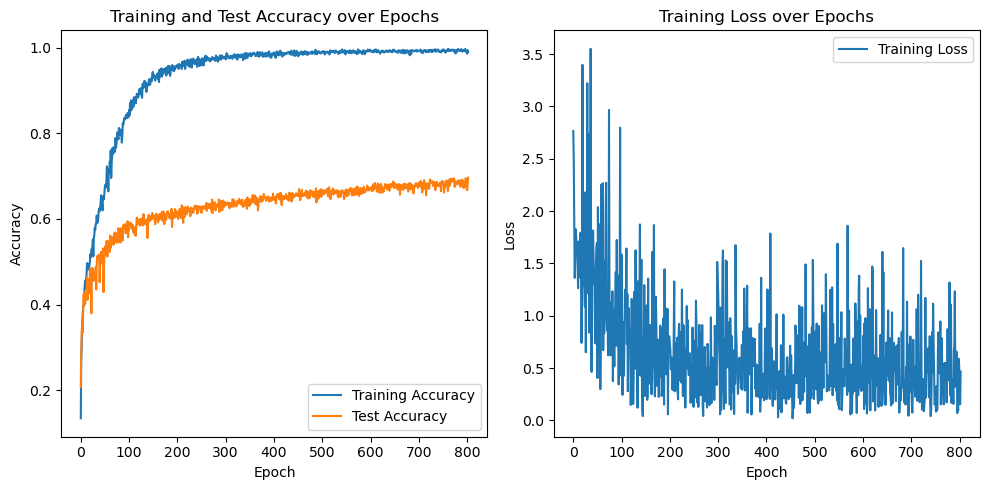

In [ ]:
import matplotlib.pyplot as plt

# Plot training and test accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(803), history["train_acc"], label='Training Accuracy')
plt.plot(range(803), history["test_acc"], label='Test Accuracy')
plt.legend()
plt.title('Training and Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(803), history["loss"], label='Training Loss')
plt.legend()
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


##### μ = 7

In [ ]:
pwd

'/kaggle/working'

In [ ]:
import tensorflow as tf
from tensorflow import keras
import math
import os

# Specify the directory to save the model weights
weights_dir = "/kaggle/working"
os.makedirs(weights_dir, exist_ok=True)


# Initialisation de l'historique
history = {"loss": [], "train_acc": [], "test_acc": []}


# Création du model
model = create_model()

# Treshold
tau = 0.95

# For example, μ = 2 means that we use twice the number of unlabeled images compared to labeled images.
mu = 7

# Weight decay coefficient
weight_decay = 0.0003

# Nombre d'epochs de l'apprentissage
epochs = 800

# Nombre de données labellisées par batch
bs_lab = 10

# Nombre de données non-labellisées par batch
bs_unlab = mu * bs_lab

# # Taille du batch
batch_size = bs_lab + bs_unlab

# Nombre de batches par epochs
if batch_size < x_train_lab.shape[0]:
    steps_per_epoch = math.floor(x_train_lab.shape[0]/batch_size)
else:
    steps_per_epoch = 1
    batch_size = x_train_lab.shape[0]

# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
# optimizer = tf.keras.optimizers.SGD(lr=0.1, momentum=0.9)

# Pour la partie supervisée de la perte
loss_sup = keras.losses.SparseCategoricalCrossentropy()

# Préparation des métriques pour le suivi de la performance du modèle.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
test_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# Indices de l'ensemble non labellisé
indices_lab = np.arange(x_train_lab.shape[0])
# Indices de l'ensemble non labellisé
indices_unlab = np.arange(x_train_unlab.shape[0])

for epoch in range(epochs):

  # A chaque nouvelle epoch, on randomise les indices de l'ensemble labellisé
  np.random.shuffle(indices_lab)

  # A chaque nouvelle epoch, on randomise les indices de l'ensemble non labellisé
  np.random.shuffle(indices_unlab)

  for b in range(steps_per_epoch):

    # Les données d'un batch sont constituées de l'intégralité de nos données labellisées...
    x_batch_lab = x_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    y_batch_lab = y_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]

    y_batch_lab = np.expand_dims(y_batch_lab, 1)

    # ... ainsi que de données non-labellisées !
    x_batch_unlab = x_train_unlab[indices_unlab[b*bs_unlab:(b+1)*bs_unlab]]

    # On forme notre batch en concaténant les données labellisées et non labellisées
    x_batch = np.concatenate((x_batch_lab, x_batch_unlab), axis=0)

    # On forme également un batch augmenté avec weak augment
    x_batch_weak = train_datagen.flow(x_batch, shuffle=False, batch_size=batch_size).next()

    x_batch_strong = randaugment(x_batch_unlab)

    # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
    # la différentiation automatique.
    with tf.GradientTape() as tape:

      # Application du réseau aux données d'entrée
      y_pred = model(x_batch, training=True)

      y_pred_weak = model(x_batch_weak, training=True)

      y_pred_strong = model(x_batch_strong, training=True)

      # Calcul de la fonction de perte sur ce batch
      #sup_term = loss_sup(y_batch_lab, y_pred[0:bs_lab])
      sup_term = loss_sup(y_batch_lab, y_pred_weak[:bs_lab])

      unsup_term = unlab_loss(y_pred_weak[bs_lab:], y_pred_strong, threshold = tau)

      # Add weight decay
      wd_loss = weight_decay * tf.reduce_sum([tf.nn.l2_loss(w) for w in model.trainable_weights])

      loss_value = sup_term + unsup_term

      # Calcul des gradients par différentiation automatique
      grads = tape.gradient(loss_value, model.trainable_weights)

      # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

      # Mise à jour de la métrique
      train_acc_metric.update_state(y_batch_lab, y_pred_weak[:bs_lab])


  # Calcul de la précision à la fin de l'epoch
  train_acc = train_acc_metric.result()
  # Calcul de la précision sur l'ensemble de test à la fin de l'epoch
  test_logits = model(x_test, training=False)
  test_acc_metric.update_state(np.expand_dims(y_test, 1), test_logits)
  test_acc = test_acc_metric.result()

  print("Epoch %4d : Loss : %.4f, Acc : %.4f, Test Acc : %.4f" % (epoch, float(loss_value), float(train_acc), float(test_acc)))

  history["loss"].append(float(loss_value))
  history["train_acc"].append(float(train_acc))
  history["test_acc"].append(float(test_acc))

  # Remise à zéro des métriques pour la prochaine epoch
  train_acc_metric.reset_states()
  test_acc_metric.reset_states()


# Save the model weights after the end of training
model.save_weights(os.path.join(weights_dir, "model_weights_10percent_mu7.h5"))

Epoch    0 : Loss : 6.8100, Acc : 0.1226, Test Acc : 0.1256
Epoch    1 : Loss : 5.7265, Acc : 0.1935, Test Acc : 0.2130
Epoch    2 : Loss : 2.7634, Acc : 0.1839, Test Acc : 0.2386
Epoch    3 : Loss : 2.2420, Acc : 0.2097, Test Acc : 0.2135
Epoch    4 : Loss : 2.3670, Acc : 0.2903, Test Acc : 0.2663
Epoch    5 : Loss : 3.2241, Acc : 0.2645, Test Acc : 0.2618
Epoch    6 : Loss : 1.7381, Acc : 0.3548, Test Acc : 0.3238
Epoch    7 : Loss : 1.9949, Acc : 0.3226, Test Acc : 0.3205
Epoch    8 : Loss : 2.5217, Acc : 0.3258, Test Acc : 0.2418
Epoch    9 : Loss : 2.4282, Acc : 0.3016, Test Acc : 0.2891
Epoch   10 : Loss : 1.3338, Acc : 0.3565, Test Acc : 0.3541
Epoch   11 : Loss : 2.6156, Acc : 0.3613, Test Acc : 0.3715
Epoch   12 : Loss : 1.9382, Acc : 0.3903, Test Acc : 0.3755
Epoch   13 : Loss : 2.1078, Acc : 0.3452, Test Acc : 0.3456
Epoch   14 : Loss : 1.9427, Acc : 0.4306, Test Acc : 0.3470
Epoch   15 : Loss : 1.6068, Acc : 0.3871, Test Acc : 0.3781
Epoch   16 : Loss : 1.4868, Acc : 0.3855

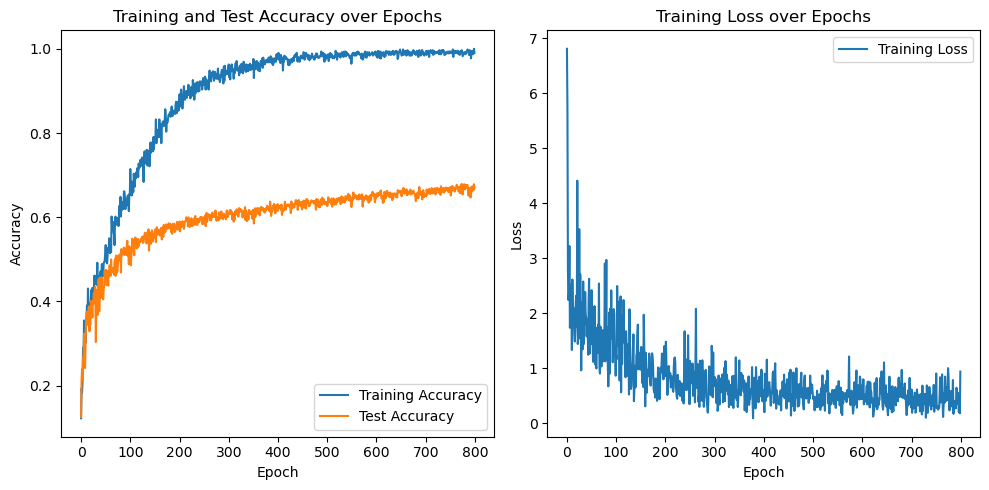

In [ ]:
import matplotlib.pyplot as plt

# Plot training and test accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), history["train_acc"], label='Training Accuracy')
plt.plot(range(epochs), history["test_acc"], label='Test Accuracy')
plt.legend()
plt.title('Training and Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), history["loss"], label='Training Loss')
plt.legend()
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


##### μ = 10

In [ ]:
import tensorflow as tf
from tensorflow import keras
import math
import os

# Specify the directory to save the model weights
weights_dir = "/kaggle/working"
os.makedirs(weights_dir, exist_ok=True)


# Initialisation de l'historique
history = {"loss": [], "train_acc": [], "test_acc": []}


# Création du model
model = create_model()

# Treshold
tau = 0.95

# For example, μ = 2 means that we use twice the number of unlabeled images compared to labeled images.
mu = 10

# Weight decay coefficient
weight_decay = 0.0005

# Nombre d'epochs de l'apprentissage
epochs = 800

# Nombre de données labellisées par batch
bs_lab = 10

# Nombre de données non-labellisées par batch
bs_unlab = mu * bs_lab

# # Taille du batch
batch_size = bs_lab + bs_unlab

# Nombre de batches par epochs
if batch_size < x_train_lab.shape[0]:
    steps_per_epoch = math.floor(x_train_lab.shape[0]/batch_size)
else:
    steps_per_epoch = 1
    batch_size = x_train_lab.shape[0]

# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
# optimizer = tf.keras.optimizers.SGD(lr=0.1, momentum=0.9)

# Pour la partie supervisée de la perte
loss_sup = keras.losses.SparseCategoricalCrossentropy()

# Préparation des métriques pour le suivi de la performance du modèle.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
test_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# Indices de l'ensemble non labellisé
indices_lab = np.arange(x_train_lab.shape[0])
# Indices de l'ensemble non labellisé
indices_unlab = np.arange(x_train_unlab.shape[0])

for epoch in range(epochs):

  # A chaque nouvelle epoch, on randomise les indices de l'ensemble labellisé
  np.random.shuffle(indices_lab)

  # A chaque nouvelle epoch, on randomise les indices de l'ensemble non labellisé
  np.random.shuffle(indices_unlab)

  for b in range(steps_per_epoch):

    # Les données d'un batch sont constituées de l'intégralité de nos données labellisées...
    x_batch_lab = x_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    y_batch_lab = y_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]

    y_batch_lab = np.expand_dims(y_batch_lab, 1)

    # ... ainsi que de données non-labellisées !
    x_batch_unlab = x_train_unlab[indices_unlab[b*bs_unlab:(b+1)*bs_unlab]]

    # On forme notre batch en concaténant les données labellisées et non labellisées
    x_batch = np.concatenate((x_batch_lab, x_batch_unlab), axis=0)

    # On forme également un batch augmenté avec weak augment
    x_batch_weak = train_datagen.flow(x_batch, shuffle=False, batch_size=batch_size).next()

    x_batch_strong = randaugment(x_batch_unlab)

    # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
    # la différentiation automatique.
    with tf.GradientTape() as tape:

      # Application du réseau aux données d'entrée
      y_pred = model(x_batch, training=True)

      y_pred_weak = model(x_batch_weak, training=True)

      y_pred_strong = model(x_batch_strong, training=True)

      # Calcul de la fonction de perte sur ce batch
      #sup_term = loss_sup(y_batch_lab, y_pred[0:bs_lab])
      sup_term = loss_sup(y_batch_lab, y_pred_weak[:bs_lab])

      unsup_term = unlab_loss(y_pred_weak[bs_lab:], y_pred_strong, threshold = tau)

      # Add weight decay
      wd_loss = weight_decay * tf.reduce_sum([tf.nn.l2_loss(w) for w in model.trainable_weights])

      loss_value = sup_term + unsup_term

      # Calcul des gradients par différentiation automatique
      grads = tape.gradient(loss_value, model.trainable_weights)

      # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

      # Mise à jour de la métrique
      train_acc_metric.update_state(y_batch_lab, y_pred_weak[:bs_lab])


  # Calcul de la précision à la fin de l'epoch
  train_acc = train_acc_metric.result()
  # Calcul de la précision sur l'ensemble de test à la fin de l'epoch
  test_logits = model(x_test, training=False)
  test_acc_metric.update_state(np.expand_dims(y_test, 1), test_logits)
  test_acc = test_acc_metric.result()

  print("Epoch %4d : Loss : %.4f, Acc : %.4f, Test Acc : %.4f" % (epoch, float(loss_value), float(train_acc), float(test_acc)))

  history["loss"].append(float(loss_value))
  history["train_acc"].append(float(train_acc))
  history["test_acc"].append(float(test_acc))

  # Remise à zéro des métriques pour la prochaine epoch
  train_acc_metric.reset_states()
  test_acc_metric.reset_states()


# Save the model weights after the end of training
model.save_weights(os.path.join(weights_dir, "model_weights_10percent_mu10.h5"))

Epoch    0 : Loss : 9.3590, Acc : 0.1489, Test Acc : 0.1548
Epoch    1 : Loss : 6.4843, Acc : 0.1889, Test Acc : 0.1958
Epoch    2 : Loss : 3.0025, Acc : 0.1978, Test Acc : 0.2161
Epoch    3 : Loss : 2.5740, Acc : 0.2356, Test Acc : 0.2664
Epoch    4 : Loss : 2.3944, Acc : 0.2222, Test Acc : 0.2538
Epoch    5 : Loss : 3.0031, Acc : 0.2156, Test Acc : 0.2163
Epoch    6 : Loss : 4.3374, Acc : 0.2756, Test Acc : 0.1938
Epoch    7 : Loss : 1.4773, Acc : 0.2644, Test Acc : 0.3044
Epoch    8 : Loss : 2.6642, Acc : 0.3089, Test Acc : 0.1770
Epoch    9 : Loss : 2.2373, Acc : 0.2733, Test Acc : 0.2963
Epoch   10 : Loss : 1.8394, Acc : 0.3733, Test Acc : 0.3113
Epoch   11 : Loss : 2.1085, Acc : 0.3044, Test Acc : 0.2991
Epoch   12 : Loss : 1.7546, Acc : 0.3000, Test Acc : 0.3076
Epoch   13 : Loss : 3.5681, Acc : 0.3022, Test Acc : 0.2986
Epoch   14 : Loss : 1.9735, Acc : 0.3044, Test Acc : 0.2908
Epoch   15 : Loss : 1.7575, Acc : 0.3444, Test Acc : 0.2958
Epoch   16 : Loss : 2.5819, Acc : 0.3622

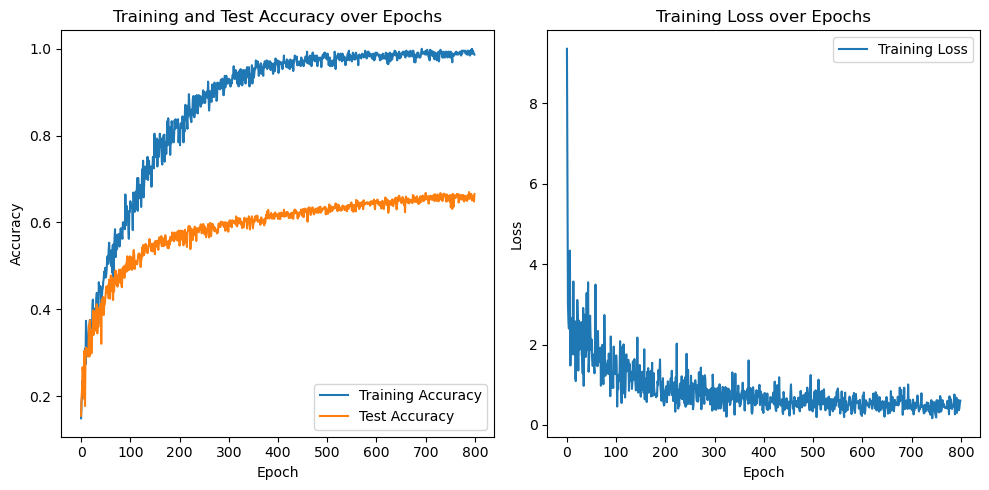

In [ ]:
import matplotlib.pyplot as plt

# Plot training and test accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), history["train_acc"], label='Training Accuracy')
plt.plot(range(epochs), history["test_acc"], label='Test Accuracy')
plt.legend()
plt.title('Training and Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), history["loss"], label='Training Loss')
plt.legend()
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


### Fix Match avec 5% de données labellisées (2500)


In [ ]:
x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test = generate_data_cifar(0.95)

In [ ]:
# x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test = generate_cifar_dataset_perc(labeled_percent=0.1)
# Print shapes
print("Shape of x_train_lab:", np.shape(x_train_lab))
print("Shape of y_train_lab:", np.shape(y_train_lab))
print("Shape of x_train_unlab:", np.shape(x_train_unlab))
print("Shape of y_train_unlab:", np.shape(y_train_unlab))
print("Shape of x_test:", np.shape(x_test))
print("Shape of y_test:", np.shape(y_test))

Shape of x_train_lab: (2500, 32, 32, 3)

Shape of y_train_lab: (2500, 1)

Shape of x_train_unlab: (47500, 32, 32, 3)

Shape of y_train_unlab: (47500, 1)

Shape of x_test: (10000, 32, 32, 3)

Shape of y_test: (10000, 1)


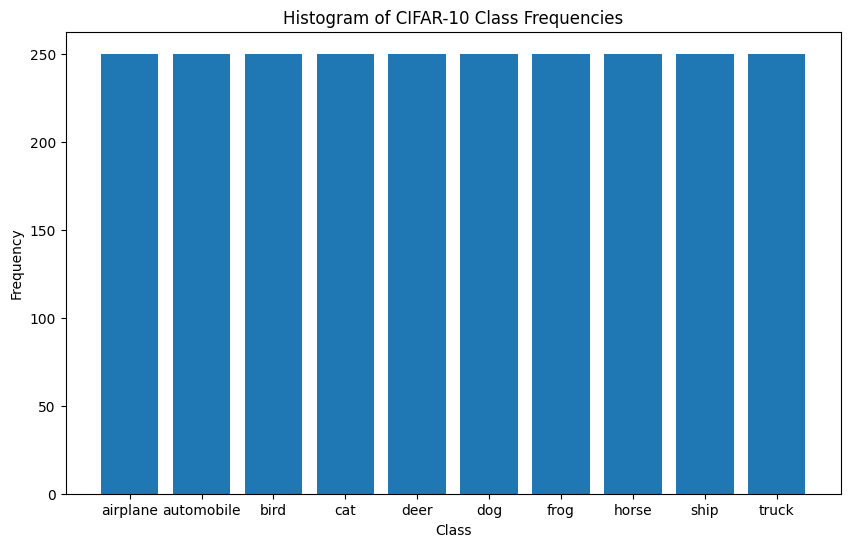

In [ ]:
# Compute class frequencies
class_frequencies = np.histogram(y_train_lab, bins=range(11))[0]

# Plot histogram with increased figure size
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(10), class_frequencies)
ax.set_xticks(range(10))
ax.set_xticklabels(['airplane', 'automobile', 'bird', 'cat', 'deer',
                     'dog', 'frog', 'horse', 'ship', 'truck'])
ax.set_xlabel('Class')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of CIFAR-10 Class Frequencies')
plt.show()


#### μ = 2

In [ ]:
import tensorflow as tf
from tensorflow import keras
import math
import os

# Specify the directory to save the model weights
weights_dir = "/content"
os.makedirs(weights_dir, exist_ok=True)


# Initialisation de l'historique
history = {"loss": [], "train_acc": [], "test_acc": []}


# Création du model
model = create_model()

# Treshold
tau = 0.95

# For example, μ = 2 means that we use twice the number of unlabeled images compared to labeled images.
mu = 2

# Weight decay coefficient
weight_decay = 0.0003

# Nombre d'epochs de l'apprentissage
epochs = 800

# Nombre de données labellisées par batch
bs_lab = 10

# Nombre de données non-labellisées par batch
bs_unlab = mu * bs_lab

# # Taille du batch
batch_size = bs_lab + bs_unlab

# Nombre de batches par epochs
if batch_size < x_train_lab.shape[0]:
    steps_per_epoch = math.floor(x_train_lab.shape[0]/batch_size)
else:
    steps_per_epoch = 1
    batch_size = x_train_lab.shape[0]

# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
# optimizer = tf.keras.optimizers.SGD(lr=0.1, momentum=0.9)

# Pour la partie supervisée de la perte
loss_sup = keras.losses.SparseCategoricalCrossentropy()

# Préparation des métriques pour le suivi de la performance du modèle.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
test_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# Indices de l'ensemble non labellisé
indices_lab = np.arange(x_train_lab.shape[0])
# Indices de l'ensemble non labellisé
indices_unlab = np.arange(x_train_unlab.shape[0])

for epoch in range(epochs):

  # A chaque nouvelle epoch, on randomise les indices de l'ensemble labellisé
  np.random.shuffle(indices_lab)

  # A chaque nouvelle epoch, on randomise les indices de l'ensemble non labellisé
  np.random.shuffle(indices_unlab)

  for b in range(steps_per_epoch):

    # Les données d'un batch sont constituées de l'intégralité de nos données labellisées...
    x_batch_lab = x_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    y_batch_lab = y_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]

    y_batch_lab = np.expand_dims(y_batch_lab, 1)

    # ... ainsi que de données non-labellisées !
    x_batch_unlab = x_train_unlab[indices_unlab[b*bs_unlab:(b+1)*bs_unlab]]

    # On forme notre batch en concaténant les données labellisées et non labellisées
    x_batch = np.concatenate((x_batch_lab, x_batch_unlab), axis=0)

    # On forme également un batch augmenté avec weak augment
    x_batch_weak = train_datagen.flow(x_batch, shuffle=False, batch_size=batch_size).next()

    x_batch_strong = randaugment(x_batch_unlab)

    # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
    # la différentiation automatique.
    with tf.GradientTape() as tape:

      # Application du réseau aux données d'entrée
      y_pred = model(x_batch, training=True)

      y_pred_weak = model(x_batch_weak, training=True)

      y_pred_strong = model(x_batch_strong, training=True)

      # Calcul de la fonction de perte sur ce batch
      #sup_term = loss_sup(y_batch_lab, y_pred[0:bs_lab])
      sup_term = loss_sup(y_batch_lab, y_pred_weak[:bs_lab])

      unsup_term = unlab_loss(y_pred_weak[bs_lab:], y_pred_strong, threshold = tau)

      # Add weight decay
      wd_loss = weight_decay * tf.reduce_sum([tf.nn.l2_loss(w) for w in model.trainable_weights])

      loss_value = sup_term + unsup_term

      # Calcul des gradients par différentiation automatique
      grads = tape.gradient(loss_value, model.trainable_weights)

      # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

      # Mise à jour de la métrique
      train_acc_metric.update_state(y_batch_lab, y_pred_weak[:bs_lab])


  # Calcul de la précision à la fin de l'epoch
  train_acc = train_acc_metric.result()
  # Calcul de la précision sur l'ensemble de test à la fin de l'epoch
  test_logits = model(x_test, training=False)
  test_acc_metric.update_state(np.expand_dims(y_test, 1), test_logits)
  test_acc = test_acc_metric.result()

  print("Epoch %4d : Loss : %.4f, Acc : %.4f, Test Acc : %.4f" % (epoch, float(loss_value), float(train_acc), float(test_acc)))

  history["loss"].append(float(loss_value))
  history["train_acc"].append(float(train_acc))
  history["test_acc"].append(float(test_acc))

  # Remise à zéro des métriques pour la prochaine epoch
  train_acc_metric.reset_states()
  test_acc_metric.reset_states()


# Save the model weights after the end of training
model.save_weights(os.path.join(weights_dir, "model_weights_5percent_mu2.h5"))

Epoch    0 : Loss : 9.8697, Acc : 0.1145, Test Acc : 0.1239

Epoch    1 : Loss : 3.4345, Acc : 0.1181, Test Acc : 0.1856

Epoch    2 : Loss : 1.8831, Acc : 0.2663, Test Acc : 0.2453

Epoch    3 : Loss : 1.9197, Acc : 0.2711, Test Acc : 0.2938

Epoch    4 : Loss : 2.0764, Acc : 0.3434, Test Acc : 0.2936

Epoch    5 : Loss : 1.7690, Acc : 0.3446, Test Acc : 0.3229

Epoch    6 : Loss : 2.1280, Acc : 0.3410, Test Acc : 0.3430

Epoch    7 : Loss : 1.3419, Acc : 0.4024, Test Acc : 0.3429

Epoch    8 : Loss : 2.1779, Acc : 0.4108, Test Acc : 0.3671

Epoch    9 : Loss : 1.8224, Acc : 0.4012, Test Acc : 0.3052

Epoch   10 : Loss : 1.3149, Acc : 0.4120, Test Acc : 0.4016

Epoch   11 : Loss : 1.5842, Acc : 0.4614, Test Acc : 0.3840

Epoch   12 : Loss : 1.5254, Acc : 0.4193, Test Acc : 0.3610

Epoch   13 : Loss : 1.6219, Acc : 0.4241, Test Acc : 0.3940

Epoch   14 : Loss : 1.8150, Acc : 0.4554, Test Acc : 0.3510

Epoch   15 : Loss : 1.7384, Acc : 0.4458, Test Acc : 0.4041

Epoch   16 : Loss : 1.47

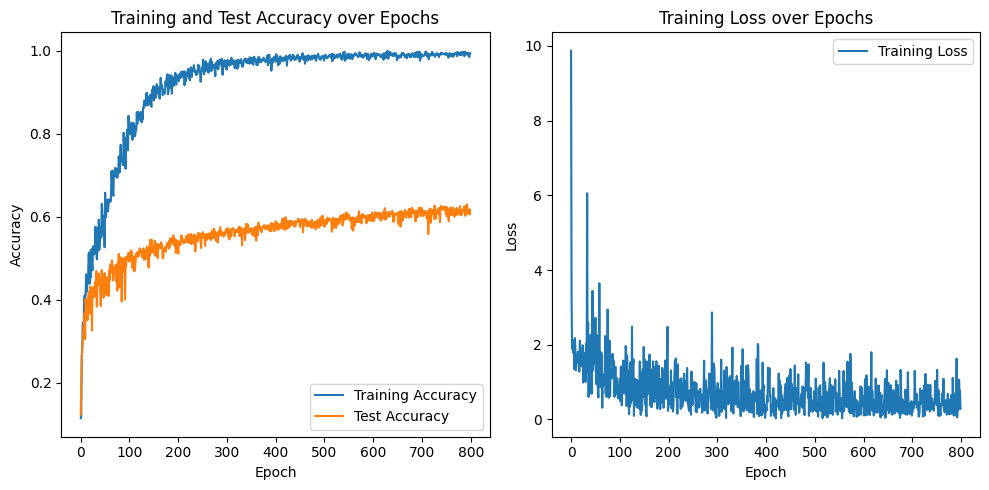

In [ ]:
import matplotlib.pyplot as plt

# Plot training and test accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), history["train_acc"], label='Training Accuracy')
plt.plot(range(epochs), history["test_acc"], label='Test Accuracy')
plt.legend()
plt.title('Training and Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), history["loss"], label='Training Loss')
plt.legend()
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


#### μ = 7

In [ ]:
import tensorflow as tf
from tensorflow import keras
import math
import os

# Specify the directory to save the model weights
weights_dir = "/content"
os.makedirs(weights_dir, exist_ok=True)


# Initialisation de l'historique
history = {"loss": [], "train_acc": [], "test_acc": []}


# Création du model
model = create_model()

# Treshold
tau = 0.95

# For example, μ = 2 means that we use twice the number of unlabeled images compared to labeled images.
mu = 7

# Weight decay coefficient
weight_decay = 0.0003

# Nombre d'epochs de l'apprentissage
epochs = 800

# Nombre de données labellisées par batch
bs_lab = 10

# Nombre de données non-labellisées par batch
bs_unlab = mu * bs_lab

# # Taille du batch
batch_size = bs_lab + bs_unlab

# Nombre de batches par epochs
if batch_size < x_train_lab.shape[0]:
    steps_per_epoch = math.floor(x_train_lab.shape[0]/batch_size)
else:
    steps_per_epoch = 1
    batch_size = x_train_lab.shape[0]

# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
# optimizer = tf.keras.optimizers.SGD(lr=0.1, momentum=0.9)

# Pour la partie supervisée de la perte
loss_sup = keras.losses.SparseCategoricalCrossentropy()

# Préparation des métriques pour le suivi de la performance du modèle.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
test_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# Indices de l'ensemble non labellisé
indices_lab = np.arange(x_train_lab.shape[0])
# Indices de l'ensemble non labellisé
indices_unlab = np.arange(x_train_unlab.shape[0])

for epoch in range(epochs):

  # A chaque nouvelle epoch, on randomise les indices de l'ensemble labellisé
  np.random.shuffle(indices_lab)

  # A chaque nouvelle epoch, on randomise les indices de l'ensemble non labellisé
  np.random.shuffle(indices_unlab)

  for b in range(steps_per_epoch):

    # Les données d'un batch sont constituées de l'intégralité de nos données labellisées...
    x_batch_lab = x_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    y_batch_lab = y_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]

    y_batch_lab = np.expand_dims(y_batch_lab, 1)

    # ... ainsi que de données non-labellisées !
    x_batch_unlab = x_train_unlab[indices_unlab[b*bs_unlab:(b+1)*bs_unlab]]

    # On forme notre batch en concaténant les données labellisées et non labellisées
    x_batch = np.concatenate((x_batch_lab, x_batch_unlab), axis=0)

    # On forme également un batch augmenté avec weak augment
    x_batch_weak = train_datagen.flow(x_batch, shuffle=False, batch_size=batch_size).next()

    x_batch_strong = randaugment(x_batch_unlab)

    # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
    # la différentiation automatique.
    with tf.GradientTape() as tape:

      # Application du réseau aux données d'entrée
      y_pred = model(x_batch, training=True)

      y_pred_weak = model(x_batch_weak, training=True)

      y_pred_strong = model(x_batch_strong, training=True)

      # Calcul de la fonction de perte sur ce batch
      #sup_term = loss_sup(y_batch_lab, y_pred[0:bs_lab])
      sup_term = loss_sup(y_batch_lab, y_pred_weak[:bs_lab])

      unsup_term = unlab_loss(y_pred_weak[bs_lab:], y_pred_strong, threshold = tau)

      # Add weight decay
      wd_loss = weight_decay * tf.reduce_sum([tf.nn.l2_loss(w) for w in model.trainable_weights])

      loss_value = sup_term + unsup_term

      # Calcul des gradients par différentiation automatique
      grads = tape.gradient(loss_value, model.trainable_weights)

      # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

      # Mise à jour de la métrique
      train_acc_metric.update_state(y_batch_lab, y_pred_weak[:bs_lab])


  # Calcul de la précision à la fin de l'epoch
  train_acc = train_acc_metric.result()
  # Calcul de la précision sur l'ensemble de test à la fin de l'epoch
  test_logits = model(x_test, training=False)
  test_acc_metric.update_state(np.expand_dims(y_test, 1), test_logits)
  test_acc = test_acc_metric.result()

  print("Epoch %4d : Loss : %.4f, Acc : %.4f, Test Acc : %.4f" % (epoch, float(loss_value), float(train_acc), float(test_acc)))

  history["loss"].append(float(loss_value))
  history["train_acc"].append(float(train_acc))
  history["test_acc"].append(float(test_acc))

  # Remise à zéro des métriques pour la prochaine epoch
  train_acc_metric.reset_states()
  test_acc_metric.reset_states()


# Save the model weights after the end of training
model.save_weights(os.path.join(weights_dir, "model_weights_5percent_mu7.h5"))

Epoch    0 : Loss : 12.8179, Acc : 0.0871, Test Acc : 0.1094

Epoch    1 : Loss : 11.7420, Acc : 0.1290, Test Acc : 0.1538

Epoch    2 : Loss : 11.4719, Acc : 0.1710, Test Acc : 0.1437

Epoch    3 : Loss : 13.8572, Acc : 0.1226, Test Acc : 0.1890

Epoch    4 : Loss : 13.3525, Acc : 0.1516, Test Acc : 0.1195

Epoch    5 : Loss : 10.0932, Acc : 0.1613, Test Acc : 0.1234

Epoch    6 : Loss : 3.2596, Acc : 0.1516, Test Acc : 0.1846

Epoch    7 : Loss : 3.2328, Acc : 0.1677, Test Acc : 0.1784

Epoch    8 : Loss : 3.0078, Acc : 0.2129, Test Acc : 0.1477

Epoch    9 : Loss : 2.4123, Acc : 0.2290, Test Acc : 0.2309

Epoch   10 : Loss : 1.7914, Acc : 0.2935, Test Acc : 0.2865

Epoch   11 : Loss : 2.1690, Acc : 0.3226, Test Acc : 0.2899

Epoch   12 : Loss : 1.8682, Acc : 0.3548, Test Acc : 0.3000

Epoch   13 : Loss : 1.7664, Acc : 0.3516, Test Acc : 0.3212

Epoch   14 : Loss : 2.7900, Acc : 0.3032, Test Acc : 0.1820

Epoch   15 : Loss : 3.2251, Acc : 0.2645, Test Acc : 0.2246

Epoch   16 : Loss 

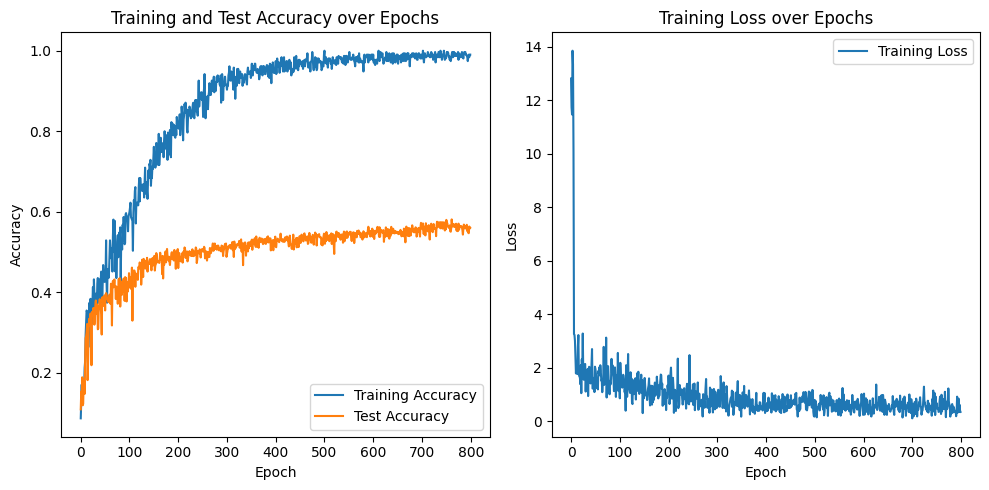

In [ ]:
import matplotlib.pyplot as plt

# Plot training and test accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), history["train_acc"], label='Training Accuracy')
plt.plot(range(epochs), history["test_acc"], label='Test Accuracy')
plt.legend()
plt.title('Training and Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), history["loss"], label='Training Loss')
plt.legend()
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


#### μ = 10

In [ ]:
import tensorflow as tf
from tensorflow import keras
import math
import os

# Specify the directory to save the model weights
weights_dir = "/content"
os.makedirs(weights_dir, exist_ok=True)


# Initialisation de l'historique
history = {"loss": [], "train_acc": [], "test_acc": []}


# Création du model
model = create_model()

# Treshold
tau = 0.95

# For example, μ = 2 means that we use twice the number of unlabeled images compared to labeled images.
mu = 10

# Weight decay coefficient
weight_decay = 0.0003

# Nombre d'epochs de l'apprentissage
epochs = 800

# Nombre de données labellisées par batch
bs_lab = 10

# Nombre de données non-labellisées par batch
bs_unlab = mu * bs_lab

# # Taille du batch
batch_size = bs_lab + bs_unlab

# Nombre de batches par epochs
if batch_size < x_train_lab.shape[0]:
    steps_per_epoch = math.floor(x_train_lab.shape[0]/batch_size)
else:
    steps_per_epoch = 1
    batch_size = x_train_lab.shape[0]

# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
# optimizer = tf.keras.optimizers.SGD(lr=0.1, momentum=0.9)

# Pour la partie supervisée de la perte
loss_sup = keras.losses.SparseCategoricalCrossentropy()

# Préparation des métriques pour le suivi de la performance du modèle.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
test_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# Indices de l'ensemble non labellisé
indices_lab = np.arange(x_train_lab.shape[0])
# Indices de l'ensemble non labellisé
indices_unlab = np.arange(x_train_unlab.shape[0])

for epoch in range(epochs):

  # A chaque nouvelle epoch, on randomise les indices de l'ensemble labellisé
  np.random.shuffle(indices_lab)

  # A chaque nouvelle epoch, on randomise les indices de l'ensemble non labellisé
  np.random.shuffle(indices_unlab)

  for b in range(steps_per_epoch):

    # Les données d'un batch sont constituées de l'intégralité de nos données labellisées...
    x_batch_lab = x_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    y_batch_lab = y_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]

    y_batch_lab = np.expand_dims(y_batch_lab, 1)

    # ... ainsi que de données non-labellisées !
    x_batch_unlab = x_train_unlab[indices_unlab[b*bs_unlab:(b+1)*bs_unlab]]

    # On forme notre batch en concaténant les données labellisées et non labellisées
    x_batch = np.concatenate((x_batch_lab, x_batch_unlab), axis=0)

    # On forme également un batch augmenté avec weak augment
    x_batch_weak = train_datagen.flow(x_batch, shuffle=False, batch_size=batch_size).next()

    x_batch_strong = randaugment(x_batch_unlab)

    # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
    # la différentiation automatique.
    with tf.GradientTape() as tape:

      # Application du réseau aux données d'entrée
      y_pred = model(x_batch, training=True)

      y_pred_weak = model(x_batch_weak, training=True)

      y_pred_strong = model(x_batch_strong, training=True)

      # Calcul de la fonction de perte sur ce batch
      #sup_term = loss_sup(y_batch_lab, y_pred[0:bs_lab])
      sup_term = loss_sup(y_batch_lab, y_pred_weak[:bs_lab])

      unsup_term = unlab_loss(y_pred_weak[bs_lab:], y_pred_strong, threshold = tau)

      # Add weight decay
      wd_loss = weight_decay * tf.reduce_sum([tf.nn.l2_loss(w) for w in model.trainable_weights])

      loss_value = sup_term + unsup_term

      # Calcul des gradients par différentiation automatique
      grads = tape.gradient(loss_value, model.trainable_weights)

      # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

      # Mise à jour de la métrique
      train_acc_metric.update_state(y_batch_lab, y_pred_weak[:bs_lab])


  # Calcul de la précision à la fin de l'epoch
  train_acc = train_acc_metric.result()
  # Calcul de la précision sur l'ensemble de test à la fin de l'epoch
  test_logits = model(x_test, training=False)
  test_acc_metric.update_state(np.expand_dims(y_test, 1), test_logits)
  test_acc = test_acc_metric.result()

  print("Epoch %4d : Loss : %.4f, Acc : %.4f, Test Acc : %.4f" % (epoch, float(loss_value), float(train_acc), float(test_acc)))

  history["loss"].append(float(loss_value))
  history["train_acc"].append(float(train_acc))
  history["test_acc"].append(float(test_acc))

  # Remise à zéro des métriques pour la prochaine epoch
  train_acc_metric.reset_states()
  test_acc_metric.reset_states()


# Save the model weights after the end of training
model.save_weights(os.path.join(weights_dir, "model_weights_5percent_mu10.h5"))

Epoch    0 : Loss : 6.1528, Acc : 0.0773, Test Acc : 0.1169

Epoch    1 : Loss : 4.0450, Acc : 0.1273, Test Acc : 0.1109

Epoch    2 : Loss : 3.9844, Acc : 0.1500, Test Acc : 0.2002

Epoch    3 : Loss : 2.6475, Acc : 0.1773, Test Acc : 0.2008

Epoch    4 : Loss : 3.8987, Acc : 0.1773, Test Acc : 0.1375

Epoch    5 : Loss : 1.6007, Acc : 0.1864, Test Acc : 0.2203

Epoch    6 : Loss : 1.7745, Acc : 0.2227, Test Acc : 0.2201

Epoch    7 : Loss : 1.7783, Acc : 0.2455, Test Acc : 0.2407

Epoch    8 : Loss : 2.1178, Acc : 0.2364, Test Acc : 0.2592

Epoch    9 : Loss : 2.3016, Acc : 0.3182, Test Acc : 0.2792

Epoch   10 : Loss : 2.4025, Acc : 0.2500, Test Acc : 0.2298

Epoch   11 : Loss : 2.3732, Acc : 0.3091, Test Acc : 0.3068

Epoch   12 : Loss : 2.0216, Acc : 0.2909, Test Acc : 0.2766

Epoch   13 : Loss : 1.9290, Acc : 0.2318, Test Acc : 0.2948

Epoch   14 : Loss : 3.5378, Acc : 0.3000, Test Acc : 0.2869

Epoch   15 : Loss : 2.0049, Acc : 0.3545, Test Acc : 0.2898

Epoch   16 : Loss : 3.08

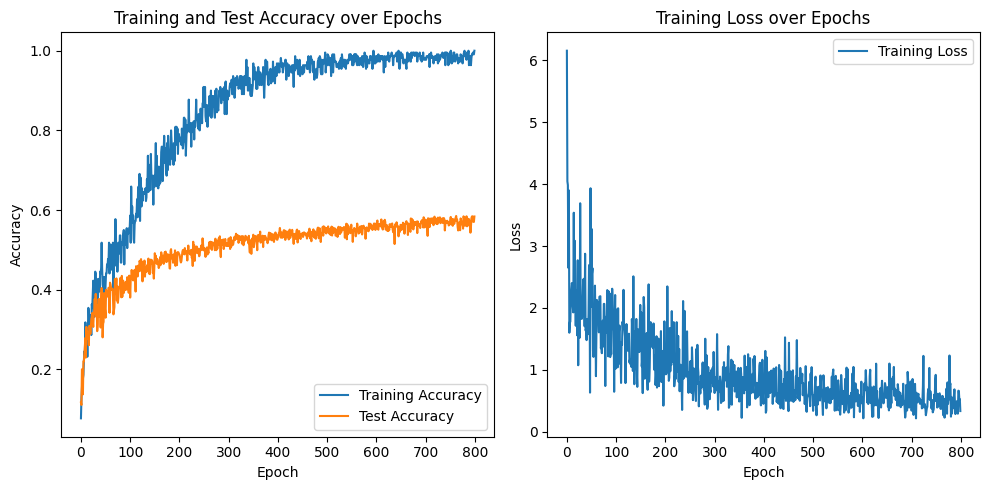

In [ ]:
import matplotlib.pyplot as plt

# Plot training and test accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), history["train_acc"], label='Training Accuracy')
plt.plot(range(epochs), history["test_acc"], label='Test Accuracy')
plt.legend()
plt.title('Training and Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), history["loss"], label='Training Loss')
plt.legend()
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


### Fix Match avec 1% de données labellisées (500)


In [ ]:
x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test = generate_data_cifar(0.99)

In [ ]:
# x_train_lab, y_train_lab, x_train_unlab, y_train_unlab, x_test, y_test = generate_cifar_dataset_perc(labeled_percent=0.1)
# Print shapes
print("Shape of x_train_lab:", np.shape(x_train_lab))
print("Shape of y_train_lab:", np.shape(y_train_lab))
print("Shape of x_train_unlab:", np.shape(x_train_unlab))
print("Shape of y_train_unlab:", np.shape(y_train_unlab))
print("Shape of x_test:", np.shape(x_test))
print("Shape of y_test:", np.shape(y_test))

Shape of x_train_lab: (500, 32, 32, 3)

Shape of y_train_lab: (500, 1)

Shape of x_train_unlab: (49500, 32, 32, 3)

Shape of y_train_unlab: (49500, 1)

Shape of x_test: (10000, 32, 32, 3)

Shape of y_test: (10000, 1)


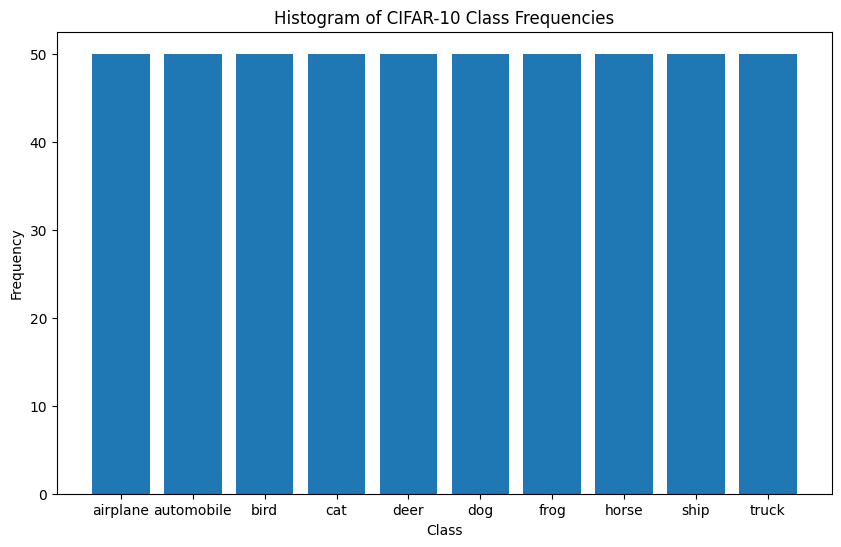

In [ ]:
# Compute class frequencies
class_frequencies = np.histogram(y_train_lab, bins=range(11))[0]

# Plot histogram with increased figure size
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(10), class_frequencies)
ax.set_xticks(range(10))
ax.set_xticklabels(['airplane', 'automobile', 'bird', 'cat', 'deer',
                     'dog', 'frog', 'horse', 'ship', 'truck'])
ax.set_xlabel('Class')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of CIFAR-10 Class Frequencies')
plt.show()


#### μ = 2 (800 epochs)

In [ ]:
import tensorflow as tf
from tensorflow import keras
import math
import os

# Specify the directory to save the model weights
weights_dir = "/content"
os.makedirs(weights_dir, exist_ok=True)


# Initialisation de l'historique
history = {"loss": [], "train_acc": [], "test_acc": []}


# Création du model
model = create_model()

# Treshold
tau = 0.95

# For example, μ = 2 means that we use twice the number of unlabeled images compared to labeled images.
mu = 2

# Weight decay coefficient
weight_decay = 0.0003

# Nombre d'epochs de l'apprentissage
epochs = 800

# Nombre de données labellisées par batch
bs_lab = 64

# Nombre de données non-labellisées par batch
bs_unlab = mu * bs_lab

# # Taille du batch
batch_size = bs_lab + bs_unlab

# Nombre de batches par epochs
if batch_size < x_train_lab.shape[0]:
    steps_per_epoch = math.floor(x_train_lab.shape[0]/batch_size)
else:
    steps_per_epoch = 1
    batch_size = x_train_lab.shape[0]

# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
# optimizer = tf.keras.optimizers.SGD(lr=0.1, momentum=0.9)

# Pour la partie supervisée de la perte
loss_sup = keras.losses.SparseCategoricalCrossentropy()

# Préparation des métriques pour le suivi de la performance du modèle.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
test_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# Indices de l'ensemble non labellisé
indices_lab = np.arange(x_train_lab.shape[0])
# Indices de l'ensemble non labellisé
indices_unlab = np.arange(x_train_unlab.shape[0])

for epoch in range(epochs):

  # A chaque nouvelle epoch, on randomise les indices de l'ensemble labellisé
  np.random.shuffle(indices_lab)

  # A chaque nouvelle epoch, on randomise les indices de l'ensemble non labellisé
  np.random.shuffle(indices_unlab)

  for b in range(steps_per_epoch):

    # Les données d'un batch sont constituées de l'intégralité de nos données labellisées...
    x_batch_lab = x_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    y_batch_lab = y_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]

    y_batch_lab = np.expand_dims(y_batch_lab, 1)

    # ... ainsi que de données non-labellisées !
    x_batch_unlab = x_train_unlab[indices_unlab[b*bs_unlab:(b+1)*bs_unlab]]

    # On forme notre batch en concaténant les données labellisées et non labellisées
    x_batch = np.concatenate((x_batch_lab, x_batch_unlab), axis=0)

    # On forme également un batch augmenté avec weak augment
    x_batch_weak = train_datagen.flow(x_batch, shuffle=False, batch_size=batch_size).next()

    x_batch_strong = randaugment(x_batch_unlab)

    # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
    # la différentiation automatique.
    with tf.GradientTape() as tape:

      # Application du réseau aux données d'entrée
      y_pred = model(x_batch, training=True)

      y_pred_weak = model(x_batch_weak, training=True)

      y_pred_strong = model(x_batch_strong, training=True)

      # Calcul de la fonction de perte sur ce batch
      #sup_term = loss_sup(y_batch_lab, y_pred[0:bs_lab])
      sup_term = loss_sup(y_batch_lab, y_pred_weak[:bs_lab])

      unsup_term = unlab_loss(y_pred_weak[bs_lab:], y_pred_strong, threshold = tau)

      # Add weight decay
      wd_loss = weight_decay * tf.reduce_sum([tf.nn.l2_loss(w) for w in model.trainable_weights])

      loss_value = sup_term + unsup_term

      # Calcul des gradients par différentiation automatique
      grads = tape.gradient(loss_value, model.trainable_weights)

      # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

      # Mise à jour de la métrique
      train_acc_metric.update_state(y_batch_lab, y_pred_weak[:bs_lab])


  # Calcul de la précision à la fin de l'epoch
  train_acc = train_acc_metric.result()
  # Calcul de la précision sur l'ensemble de test à la fin de l'epoch
  test_logits = model(x_test, training=False)
  test_acc_metric.update_state(np.expand_dims(y_test, 1), test_logits)
  test_acc = test_acc_metric.result()

  print("Epoch %4d : Loss : %.4f, Acc : %.4f, Test Acc : %.4f" % (epoch, float(loss_value), float(train_acc), float(test_acc)))

  history["loss"].append(float(loss_value))
  history["train_acc"].append(float(train_acc))
  history["test_acc"].append(float(test_acc))

  # Remise à zéro des métriques pour la prochaine epoch
  train_acc_metric.reset_states()
  test_acc_metric.reset_states()


# Save the model weights after the end of training
model.save_weights(os.path.join(weights_dir, "model_weights_1percent_mu2.h5"))

Epoch    0 : Loss : 11.9614, Acc : 0.1172, Test Acc : 0.1255

Epoch    1 : Loss : 11.4691, Acc : 0.1094, Test Acc : 0.1098

Epoch    2 : Loss : 12.7477, Acc : 0.1094, Test Acc : 0.1147

Epoch    3 : Loss : 12.9849, Acc : 0.1172, Test Acc : 0.1441

Epoch    4 : Loss : 10.6130, Acc : 0.2109, Test Acc : 0.1204

Epoch    5 : Loss : 10.6239, Acc : 0.1172, Test Acc : 0.1178

Epoch    6 : Loss : 9.1523, Acc : 0.1562, Test Acc : 0.0991

Epoch    7 : Loss : 11.3409, Acc : 0.1172, Test Acc : 0.0980

Epoch    8 : Loss : 9.3030, Acc : 0.0781, Test Acc : 0.1076

Epoch    9 : Loss : 7.6387, Acc : 0.1484, Test Acc : 0.1317

Epoch   10 : Loss : 6.5569, Acc : 0.1094, Test Acc : 0.1127

Epoch   11 : Loss : 7.8124, Acc : 0.1172, Test Acc : 0.1167

Epoch   12 : Loss : 7.5276, Acc : 0.1016, Test Acc : 0.1304

Epoch   13 : Loss : 6.7432, Acc : 0.0859, Test Acc : 0.1426

Epoch   14 : Loss : 5.8081, Acc : 0.1562, Test Acc : 0.1271

Epoch   15 : Loss : 5.9544, Acc : 0.1484, Test Acc : 0.1377

Epoch   16 : Loss

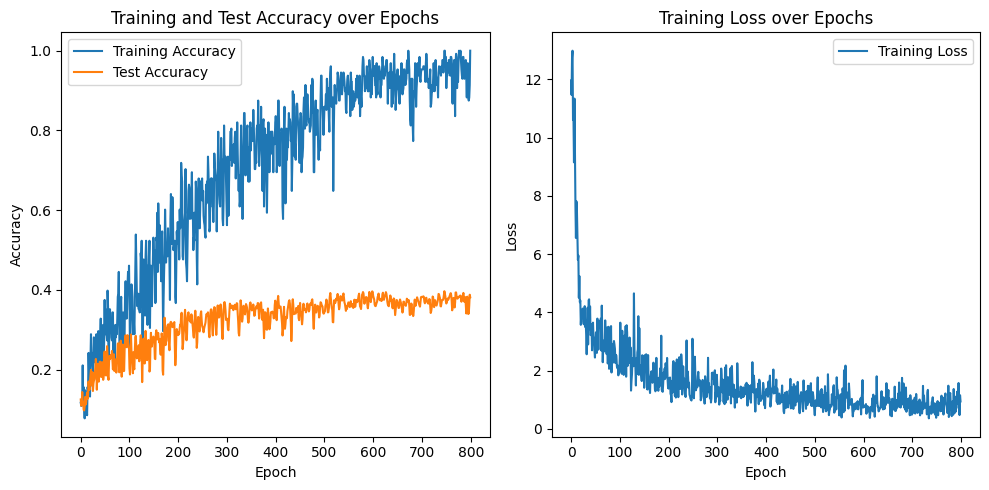

In [ ]:
import matplotlib.pyplot as plt

# Plot training and test accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), history["train_acc"], label='Training Accuracy')
plt.plot(range(epochs), history["test_acc"], label='Test Accuracy')
plt.legend()
plt.title('Training and Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), history["loss"], label='Training Loss')
plt.legend()
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


#### μ = 2 (2000 epochs)

In [ ]:
import tensorflow as tf
from tensorflow import keras
import math
import os

# Specify the directory to save the model weights
weights_dir = "/content"
os.makedirs(weights_dir, exist_ok=True)


# Initialisation de l'historique
history = {"loss": [], "train_acc": [], "test_acc": []}


# Création du model
model = create_model()

# Treshold
tau = 0.95

# For example, μ = 2 means that we use twice the number of unlabeled images compared to labeled images.
mu = 2

# Weight decay coefficient
weight_decay = 0.0003

# Nombre d'epochs de l'apprentissage
epochs = 2000

# Nombre de données labellisées par batch
bs_lab = 64

# Nombre de données non-labellisées par batch
bs_unlab = mu * bs_lab

# # Taille du batch
batch_size = bs_lab + bs_unlab

# Nombre de batches par epochs
if batch_size < x_train_lab.shape[0]:
    steps_per_epoch = math.floor(x_train_lab.shape[0]/batch_size)
else:
    steps_per_epoch = 1
    batch_size = x_train_lab.shape[0]

# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
# optimizer = tf.keras.optimizers.SGD(lr=0.1, momentum=0.9)

# Pour la partie supervisée de la perte
loss_sup = keras.losses.SparseCategoricalCrossentropy()

# Préparation des métriques pour le suivi de la performance du modèle.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
test_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# Indices de l'ensemble non labellisé
indices_lab = np.arange(x_train_lab.shape[0])
# Indices de l'ensemble non labellisé
indices_unlab = np.arange(x_train_unlab.shape[0])

for epoch in range(epochs):

  # A chaque nouvelle epoch, on randomise les indices de l'ensemble labellisé
  np.random.shuffle(indices_lab)

  # A chaque nouvelle epoch, on randomise les indices de l'ensemble non labellisé
  np.random.shuffle(indices_unlab)

  for b in range(steps_per_epoch):

    # Les données d'un batch sont constituées de l'intégralité de nos données labellisées...
    x_batch_lab = x_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]
    y_batch_lab = y_train_lab[indices_lab[b*bs_lab:(b+1)*bs_lab]]

    y_batch_lab = np.expand_dims(y_batch_lab, 1)

    # ... ainsi que de données non-labellisées !
    x_batch_unlab = x_train_unlab[indices_unlab[b*bs_unlab:(b+1)*bs_unlab]]

    # On forme notre batch en concaténant les données labellisées et non labellisées
    x_batch = np.concatenate((x_batch_lab, x_batch_unlab), axis=0)

    # On forme également un batch augmenté avec weak augment
    x_batch_weak = train_datagen.flow(x_batch, shuffle=False, batch_size=batch_size).next()

    x_batch_strong = randaugment(x_batch_unlab)

    # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
    # la différentiation automatique.
    with tf.GradientTape() as tape:

      # Application du réseau aux données d'entrée
      y_pred = model(x_batch, training=True)

      y_pred_weak = model(x_batch_weak, training=True)

      y_pred_strong = model(x_batch_strong, training=True)

      # Calcul de la fonction de perte sur ce batch
      #sup_term = loss_sup(y_batch_lab, y_pred[0:bs_lab])
      sup_term = loss_sup(y_batch_lab, y_pred_weak[:bs_lab])

      unsup_term = unlab_loss(y_pred_weak[bs_lab:], y_pred_strong, threshold = tau)

      # Add weight decay
      wd_loss = weight_decay * tf.reduce_sum([tf.nn.l2_loss(w) for w in model.trainable_weights])

      loss_value = sup_term + unsup_term

      # Calcul des gradients par différentiation automatique
      grads = tape.gradient(loss_value, model.trainable_weights)

      # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

      # Mise à jour de la métrique
      train_acc_metric.update_state(y_batch_lab, y_pred_weak[:bs_lab])


  # Calcul de la précision à la fin de l'epoch
  train_acc = train_acc_metric.result()
  # Calcul de la précision sur l'ensemble de test à la fin de l'epoch
  test_logits = model(x_test, training=False)
  test_acc_metric.update_state(np.expand_dims(y_test, 1), test_logits)
  test_acc = test_acc_metric.result()

  print("Epoch %4d : Loss : %.4f, Acc : %.4f, Test Acc : %.4f" % (epoch, float(loss_value), float(train_acc), float(test_acc)))

  history["loss"].append(float(loss_value))
  history["train_acc"].append(float(train_acc))
  history["test_acc"].append(float(test_acc))

  # Remise à zéro des métriques pour la prochaine epoch
  train_acc_metric.reset_states()
  test_acc_metric.reset_states()


# Save the model weights after the end of training
model.save_weights(os.path.join(weights_dir, "model_weights_1percent_mu7.h5"))

Epoch    0 : Loss : 12.9736, Acc : 0.1094, Test Acc : 0.1001

Epoch    1 : Loss : 12.6310, Acc : 0.0938, Test Acc : 0.1151

Epoch    2 : Loss : 12.0419, Acc : 0.1250, Test Acc : 0.1136

Epoch    3 : Loss : 10.0890, Acc : 0.1562, Test Acc : 0.1487

Epoch    4 : Loss : 11.3198, Acc : 0.1016, Test Acc : 0.1209

Epoch    5 : Loss : 9.2006, Acc : 0.1562, Test Acc : 0.1243

Epoch    6 : Loss : 9.1285, Acc : 0.1406, Test Acc : 0.1272

Epoch    7 : Loss : 9.1824, Acc : 0.1250, Test Acc : 0.1267

Epoch    8 : Loss : 9.1237, Acc : 0.1172, Test Acc : 0.1570

Epoch    9 : Loss : 8.5275, Acc : 0.2031, Test Acc : 0.1451

Epoch   10 : Loss : 8.3997, Acc : 0.1484, Test Acc : 0.1630

Epoch   11 : Loss : 7.4521, Acc : 0.2109, Test Acc : 0.1566

Epoch   12 : Loss : 7.5652, Acc : 0.1562, Test Acc : 0.1655

Epoch   13 : Loss : 5.4454, Acc : 0.2188, Test Acc : 0.1373

Epoch   14 : Loss : 6.8399, Acc : 0.1094, Test Acc : 0.1707

Epoch   15 : Loss : 4.9877, Acc : 0.2109, Test Acc : 0.1445

Epoch   16 : Loss :

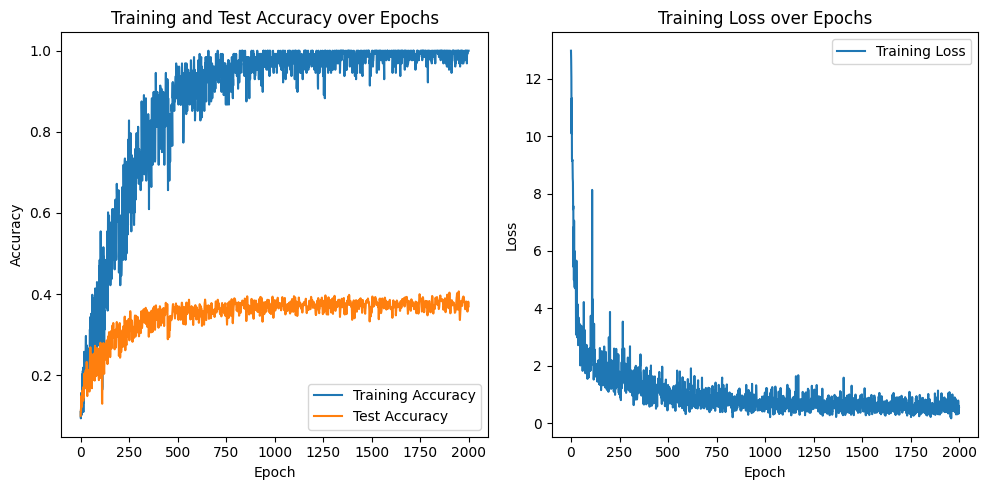

In [ ]:
import matplotlib.pyplot as plt

# Plot training and test accuracy
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), history["train_acc"], label='Training Accuracy')
plt.plot(range(epochs), history["test_acc"], label='Test Accuracy')
plt.legend()
plt.title('Training and Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), history["loss"], label='Training Loss')
plt.legend()
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


# Choix de données

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100


<ipython-input-2-f0db6e33bd0f>:68: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),


1562/1562 [==============================] - 46s 22ms/step - loss: 1.3405 - accuracy: 0.5389 - val_loss: 1.1214 - val_accuracy: 0.6062
Epoch 2/100
1562/1562 [==============================] - 34s 22ms/step - loss: 1.0065 - accuracy: 0.6599 - val_loss: 1.0755 - val_accuracy: 0.6407
Epoch 3/100
1562/1562 [==============================] - 43s 28ms/step - loss: 0.8845 - accuracy: 0.6982 - val_loss: 0.7824 - val_accuracy: 0.7428
Epoch 4/100
1562/1562 [==============================] - 33s 21ms/step - loss: 0.8089 - accuracy: 0.7236 - val_loss: 0.8310 - val_accuracy: 0.7155
Epoch 5/100
1562/1562 [==============================] - 35s 22ms/step - loss: 0.7520 - accuracy: 0.7414 - val_loss: 0.6929 - val_accuracy: 0.7646
Epoch 6/100
1562/1562 [==============================] - 34s 22ms/step - loss: 0.7110 - accuracy: 0.7554 - val_loss: 0.7710 - val_accuracy: 0.7373
Epoch 7/100
1562/1562 [==============================] - 34s 22ms/step - loss: 0.6739 - accuracy: 0.7694 - val_loss: 0.7170 - val_

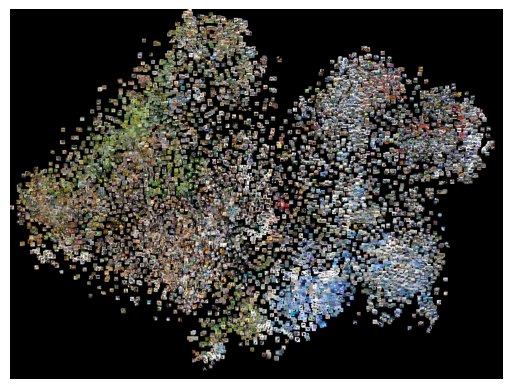

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.manifold import TSNE
from keras.utils import to_categorical
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, CSVLogger
import keras

# Load CIFAR-10 dataset
batch_size = 32
epochs = 100
num_classes = 10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Preprocess the data
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Create the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:], name='conv1'))
model.add(BatchNormalization(axis=3, name='bn_conv1'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), name='conv2'))
model.add(BatchNormalization(axis=3, name='bn_conv2'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same', name='conv3'))
model.add(BatchNormalization(axis=3, name='bn_conv3'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), name='conv4'))
model.add(BatchNormalization(axis=3, name='bn_conv4'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, name='fc1'))
model.add(BatchNormalization(axis=1, name='bn_fc1'))
model.add(Activation('relu'))
model.add(Dense(num_classes, name='output'))
model.add(BatchNormalization(axis=1, name='bn_output'))
model.add(Activation('softmax'))

# Compile the model
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False)

# Model checkpoint and CSV logger callbacks
filepath = 'v5-weights.{epoch:02d}-{val_loss:.4f}.hdf5'
model_chk = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True,
                            save_weights_only=True, mode='auto', period=1)
csv_log = CSVLogger('v5-training.log')

# Train the model
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[model_chk, csv_log])

# Extract features from 'fc1' layer
feat_extractor = Model(inputs=model.input, outputs=model.get_layer('fc1').output)
features = feat_extractor.predict(x_test, batch_size=batch_size)

# Apply t-SNE to reduce dimensionality
tsne = TSNE().fit_transform(features)
tx, ty = tsne[:, 0], tsne[:, 1]
tx = (tx - np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty - np.min(ty)) / (np.max(ty) - np.min(ty))

# Visualize the t-SNE embeddings
width = 4000
height = 3000
max_dim = 100
full_image = Image.new('RGB', (width, height))
for idx, x in enumerate(x_test):
    tile = Image.fromarray(np.uint8(x * 255))
    rs = max(1, tile.width / max_dim, tile.height / max_dim)
    tile = tile.resize((int(tile.width / rs), int(tile.height / rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width - max_dim) * tx[idx]), int((height - max_dim) * ty[idx])))

# Display or save the visualization
plt.imshow(full_image)
plt.axis('off')
plt.show()


In [ ]:
# Save tsne variable as a .npy file
# np.save('tsne.npy', tsne)
# Load tsne variable from .npy file
tsne = np.load('tsne.npy')


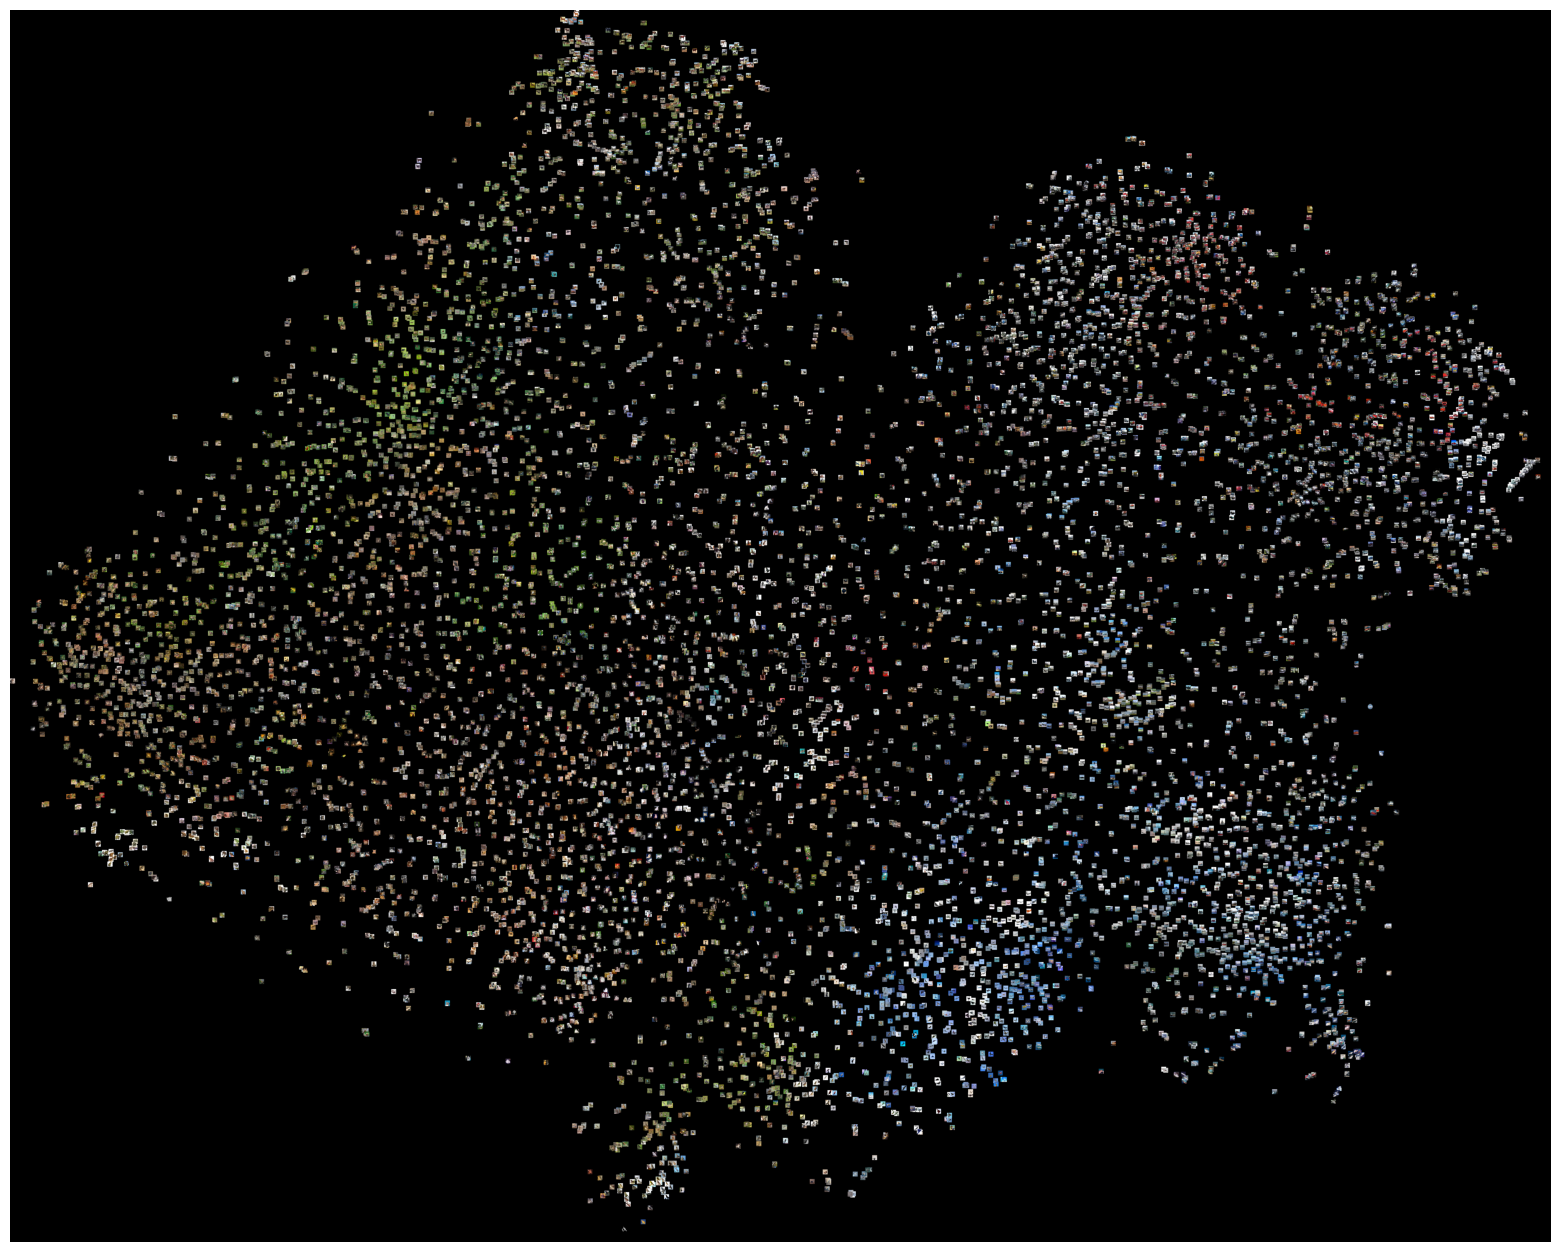

In [ ]:
# Visualize the t-SNE embeddings
width = 10000  # Increased width
height = 8000  # Increased height
max_dim = 100
full_image = Image.new('RGB', (width, height))
for idx, x in enumerate(x_test):
    tile = Image.fromarray(np.uint8(x * 255))
    rs = max(1, tile.width / max_dim, tile.height / max_dim)
    tile = tile.resize((int(tile.width / rs), int(tile.height / rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width - max_dim) * tx[idx]), int((height - max_dim) * ty[idx])))

# Display or save the visualization
plt.figure(figsize=(20, 16))  # Adjust the figsize if needed
plt.imshow(full_image)
plt.axis('off')
plt.show()


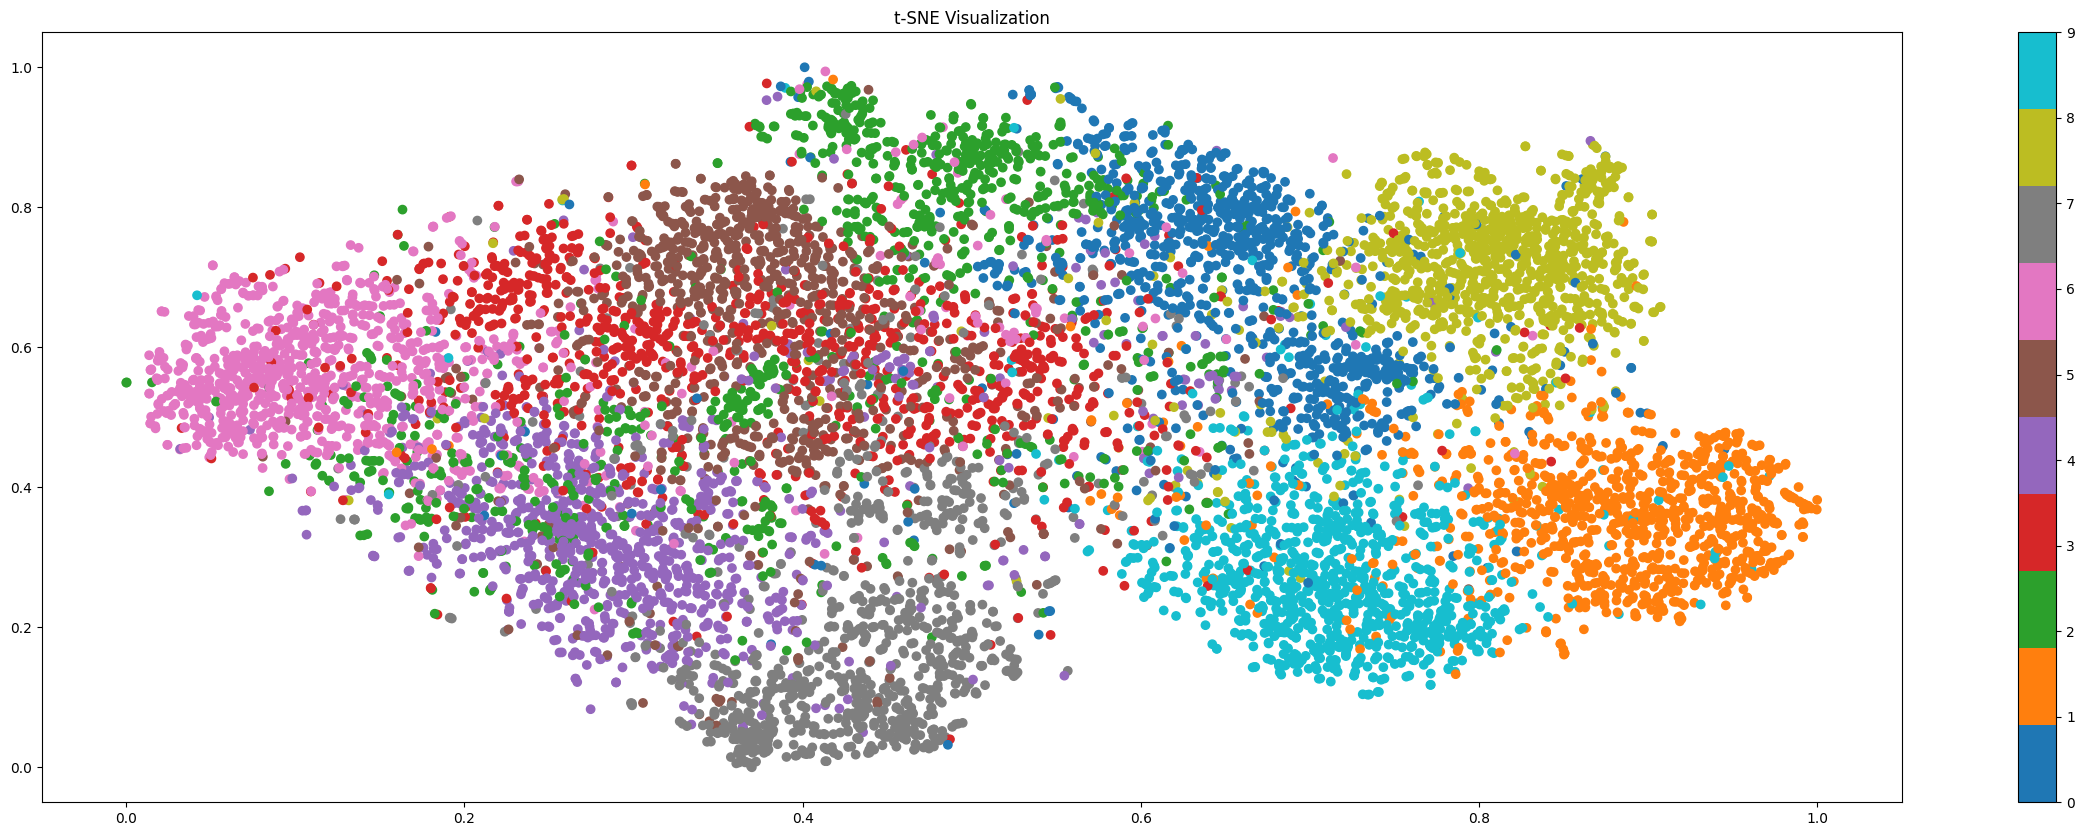

In [ ]:
# Visualize the t-SNE embeddings
plt.figure(figsize=(30, 10))
plt.scatter(tx, ty, c=np.argmax(y_test, axis=1), cmap='tab10')
plt.colorbar()
plt.title('t-SNE Visualization')
plt.show()

In [ ]:
import plotly.graph_objects as go

# Create a scatter plot with plotly
fig = go.Figure(data=go.Scatter(
    x=tx,
    y=ty,
    mode='markers',
    marker=dict(
        size=8,
        color=np.argmax(y_test, axis=1),
        colorscale='Viridis',
        showscale=True
    ),
    text=np.argmax(y_test, axis=1)
))

fig.update_layout(
    title='t-SNE Visualization',
    xaxis=dict(title='t-SNE Dimension 1'),
    yaxis=dict(title='t-SNE Dimension 2'),
    width=1500,  # Adjust the width of the plot
    height=1300  # Adjust the height of the plot
)

fig.show()
